Reference: https://www.kaggle.com/datasets/shivamb/netflix-shows/code

In [22]:
# import librairies
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

In [23]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Load the data

In [24]:
# load the data
df = pd.read_csv('MyDrive/IDS_Datasets/hulu_titles.csv')
# convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
# convert columns "director, listed_in, cast and country" in columns that contain a real list
# the strip function is applied on the elements
# if the value is NaN, the new column contains a empty list []
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,s1,Movie,Ricky Velez: Here's Everything,NaN,NaN,NaN,2021-10-24,2021,TV-MA,NaN,"Comedy, Stand Up",​Comedian Ricky Velez bares it all with his ho...,2021.0,10.0,24.0,[],"[Comedy, Stand Up]",[],[]
1,s2,Movie,Silent Night,NaN,NaN,NaN,2021-10-23,2020,NaN,94 min,"Crime, Drama, Thriller","Mark, a low end South London hitman recently r...",2021.0,10.0,23.0,[],"[Crime, Drama, Thriller]",[],[]
2,s3,Movie,The Marksman,NaN,NaN,NaN,2021-10-23,2021,PG-13,108 min,"Action, Thriller",A hardened Arizona rancher tries to protect an...,2021.0,10.0,23.0,[],"[Action, Thriller]",[],[]
3,s4,Movie,Gaia,NaN,NaN,NaN,2021-10-22,2021,R,97 min,Horror,A forest ranger and two survivalists with a cu...,2021.0,10.0,22.0,[],[Horror],[],[]
4,s5,Movie,Settlers,NaN,NaN,NaN,2021-10-22,2021,NaN,104 min,"Science Fiction, Thriller",Mankind's earliest settlers on the Martian fro...,2021.0,10.0,22.0,[],"[Science Fiction, Thriller]",[],[]
5,s6,TV Show,The Halloween Candy Magic Pet,NaN,NaN,NaN,2021-10-22,2021,NaN,1 Season,"Family, Kids",Join Mila and Morphle on a mystery-filled Hall...,2021.0,10.0,22.0,[],"[Family, Kids]",[],[]
6,s7,Movie,The Evil Next Door,NaN,NaN,NaN,2021-10-21,2020,NaN,88 min,"Horror, Thriller","New to her role as a stepmom, a young woman mo...",2021.0,10.0,21.0,[],"[Horror, Thriller]",[],[]
7,s8,TV Show,The Next Thing You Eat,NaN,NaN,NaN,2021-10-21,2021,NaN,1 Season,"Cooking & Food, Documentaries, Lifestyle & Cul...",With the unique insights and experience of Ugl...,2021.0,10.0,21.0,[],"[Cooking & Food, Documentaries, Lifestyle & Cu...",[],[]
8,s9,TV Show,Queens,NaN,NaN,NaN,2021-10-20,2021,TV-14,1 Season,"Drama, Music",Four women in their 40s reunite for a chance t...,2021.0,10.0,20.0,[],"[Drama, Music]",[],[]
9,s10,TV Show,The Bachelorette,NaN,NaN,United States,2021-10-20,2003,TV-14,3 Seasons,"Reality, Romance",ABC's romance reality show lets one lucky lady...,2021.0,10.0,20.0,[],"[Reality, Romance]",[],[United States]


In [25]:
print(df.shape)

(3073, 19)


# KMeans clustering with TF-IDF

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(df['description'].apply(lambda x: np.str_(x)) )

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

# print the centers of the clusters
# for i in range(0,k):
#     word_list=[]
#     print("cluster%d:"% i)
#     for j in centers[i,:10]:
#         word_list.append(terms[j])
#     print(word_list) 
    
request_transform = vector.transform(df['description'].apply(lambda x: np.str_(x)))
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform)

df['cluster'].value_counts().head()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


83     2629
89       96
171      70
136      56
107      32
Name: cluster, dtype: int64

<div class="alert alert-block alert-warning"><span>&#171;</span>column cluster are not going to be used because clusters are two unbalanced <br/> But tfidf will be used in order to find similar description<span>&#187;</span></div>

In [27]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

# Load the graph (undirected graph)
Nodes are :
* Movies
* Person ( actor or director)
* Categorie
* Countrie
* Cluster (description)
* Sim(title) top 5 similar movies in the sense of the description

Edges are :
* ACTED_IN : relation between an actor and a movie
* CAT_IN : relation between a categrie and a movie
* DIRECTED : relation between a director and a movie
* COU_IN : relation between a country and a movie
* DESCRIPTION : relation between a cluster and a movie
* SIMILARITY in the sense of the description

<span>&#171;</span>so, two movies are not directly connected, but they share persons, categories,clusters and countries<span>&#187;</span>


In [28]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))        

 iter 0 -- 0.015016555786132812 seconds --
 iter 1000 -- 2.810603618621826 seconds --
 iter 2000 -- 5.471131801605225 seconds --
 iter 3000 -- 8.150002241134644 seconds --
 finish -- 8.344180345535278 seconds --


# To see what's going on,a sub-graph with only two movies ...

In [29]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()



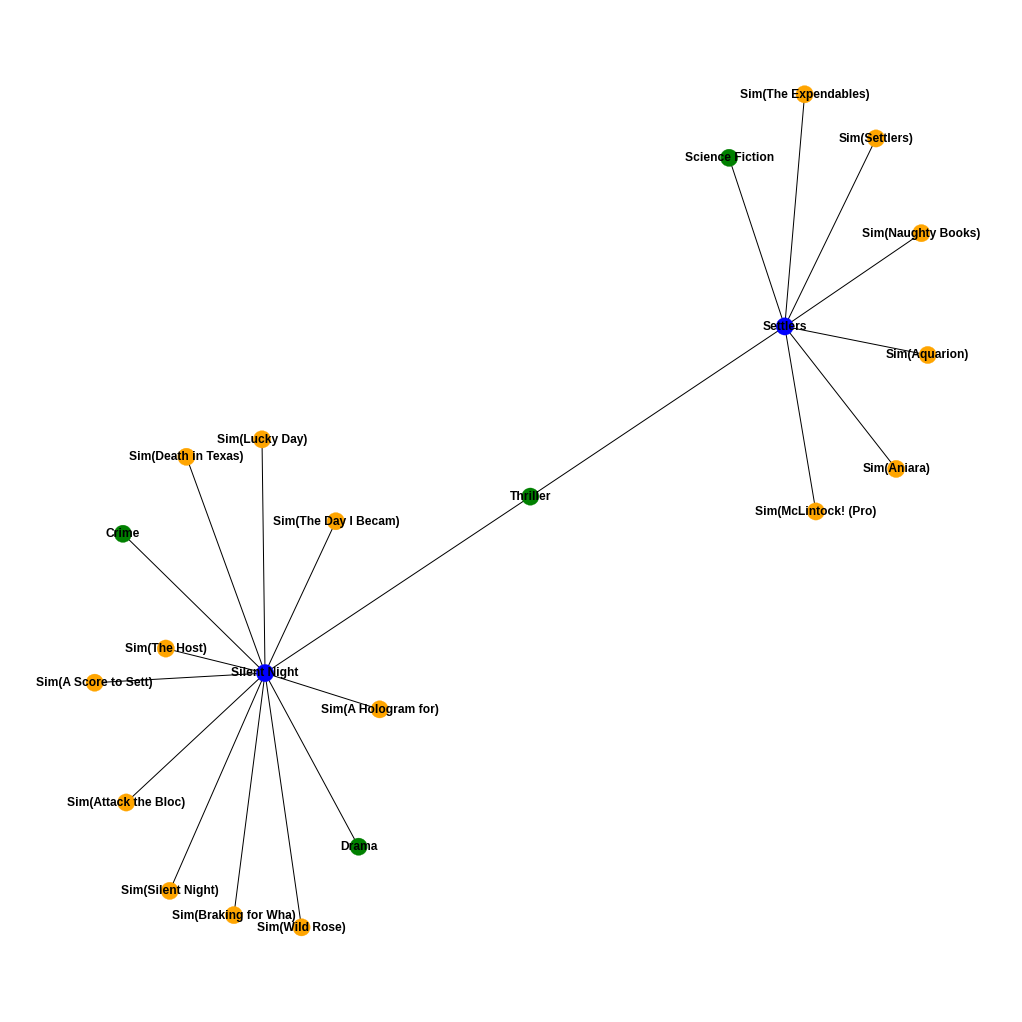

In [31]:
list_in=["Silent Night","Settlers"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

# The recommendation function
<div class="alert alert-block alert-info">
<li> Explore the neighborhood of the target film <span>&#8594;</span> this is a list of actor, director, country, categorie</li>
<li> Explore the neighborhood of each neighbor <span>&#8594;</span> discover the movies that share a node with the target field</li>
<li> Calcul Adamic Adar measure <span>&#8594;</span> final results</li>
</div>

In [32]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

# Let's test it ...

In [35]:
result = get_recommendation("Silent Night")
result2 = get_recommendation("Settlers")
result3 = get_recommendation("Gaia")
result4 = get_recommendation("The Marksman")
print("*"*40+"\n Recommendation for 'Silent Night'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Settlers'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Gaia'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'The Marksman'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for 'Silent Night'
****************************************
Lucky Day             2.974295
Death in Texas        2.416184
Wild Rose             2.379282
A Score to Settle     2.232443
Braking for Whales    1.263061
dtype: float64
****************************************
 Recommendation for 'Settlers'
****************************************
McLintock! (Producer's Cut)    1.674332
The Terror                     1.299963
Naughty Books                  1.116221
BEM                            0.927380
The Expendables 3              0.927380
dtype: float64
****************************************
 Recommendation for 'Gaia'
****************************************
Boonie Bears: Spring into Action    4.309204
In the Earth                        2.809788
Dr. Seuss: The Lorax                1.518651
Body at Brighton Rock               1.291137
Hunter Hunter                       1.291137
dtype: float64
************************************

# Draw top recommendations, to see the common nodes

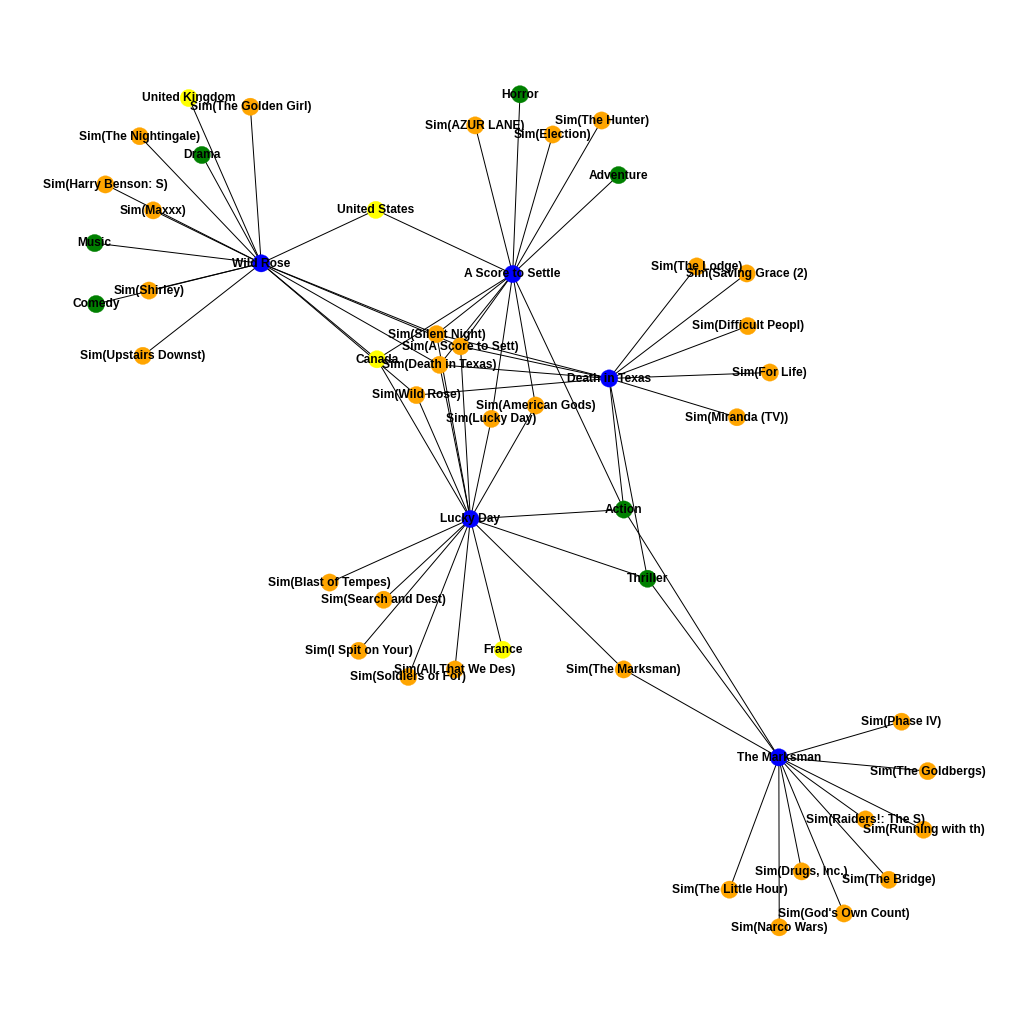

In [39]:
reco=list(result.index[:4].values)
reco.extend(["The Marksman"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

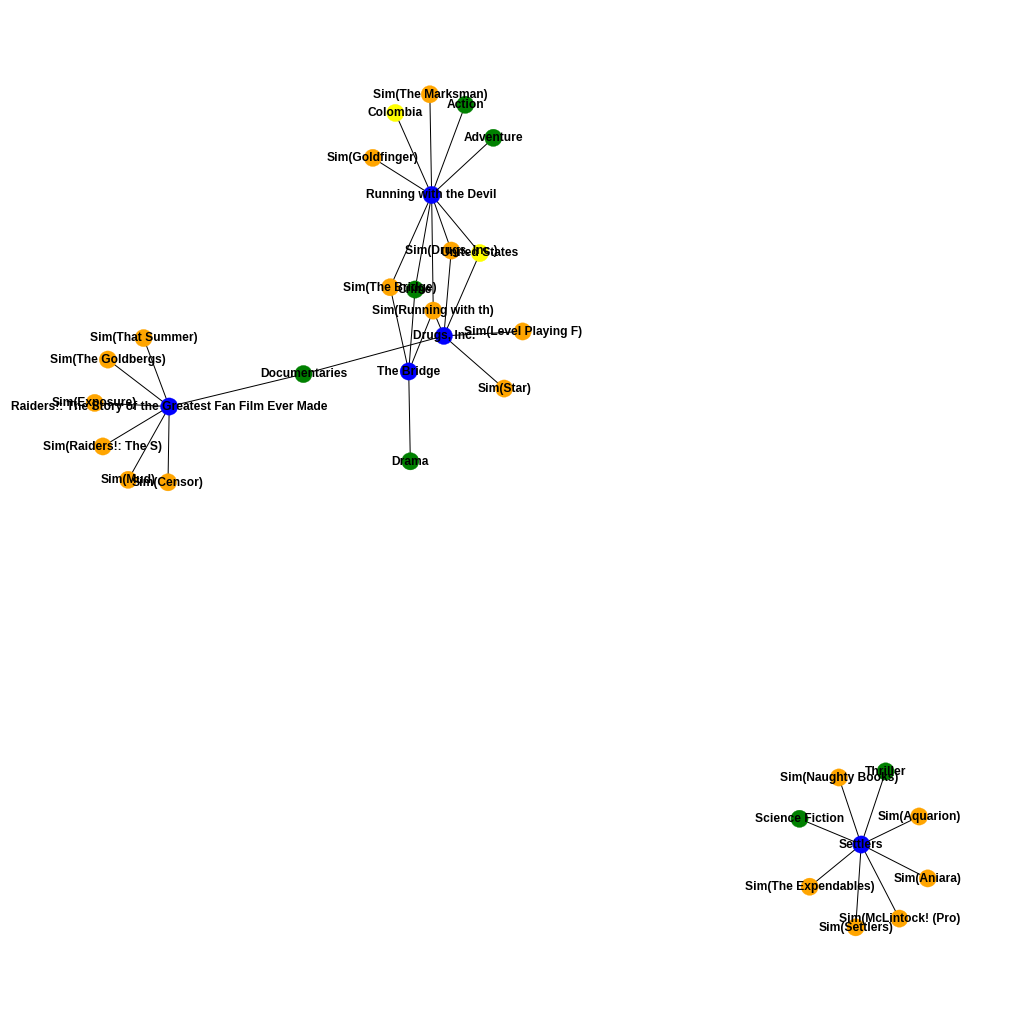

In [38]:
reco=list(result4.index[:4].values)
reco.extend(["Settlers"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)